In [ ]:
from collections import Counter
import datetime
from datasets import load_dataset
from google.colab import files
from google.colab import drive
import json
import joblib
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import psutil  # Для мониторинга памяти
import re
import random
import seaborn as sns
import spacy
from sklearn.preprocessing import LabelEncoder
from sentence_transformers import SentenceTransformer, models, losses
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from transformers import get_scheduler
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split, Dataset
from torch.nn.utils import clip_grad_norm_
import torch.nn.functional as F
from tqdm import tqdm
from tqdm.a
uto import tqdm
import time

In [ ]:
classification_big = pd.read_csv(r'/content/classification_big.csv')

Датафрейм состоит из колонок с id статей, их названиий, текстом, названием тематики, к которой относится текст и нарратива, который размечен. Под нарративом понимается стурктурно-семантическая единица текста, которая включает эмоционально окрашенную лексику и направлена на формирование положительного образа компании его транслирующий. На один текст может быть размечен один или несколько нарративов. Корпус текстов сформирован на основе новостей из федеральных и региональных СМИ. Федеральные превалируют.

In [ ]:
classification_big.head()

In [ ]:
classification_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11918 entries, 0 to 11917
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       11918 non-null  int64 
 1   pub_time         11918 non-null  object
 2   article_title    11918 non-null  object
 3   article_text     11918 non-null  object
 4   theme_label      11918 non-null  object
 5   narratives_list  11918 non-null  object
dtypes: int64(1), object(5)
memory usage: 558.8+ KB


В датасете есть тексты-авторасшифровки из России 24, которые часто представляют набор слов или отрыки предложений, которые сложно читать без аудио или видео сопровождения. Такие данные представляют собой шум и могут помешать обучению, поэтому удаляем их по слову "Авторасшифровка", которое есть во всех статьях.

In [ ]:
# Фильтруем датафрейм: оставляем только те строки, где в тексте нет слова "Авторасшифровка"
classification_big = classification_big[~classification_big['article_text'].str.contains('Авторасшифровка', na=False)].copy()

# Сбрасываем индексы
classification_big = classification_big.reset_index(drop=True)

In [ ]:
classification_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11601 entries, 0 to 11600
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_id       11601 non-null  int64 
 1   pub_time         11601 non-null  object
 2   article_title    11601 non-null  object
 3   article_text     11601 non-null  object
 4   theme_label      11601 non-null  object
 5   narratives_list  11601 non-null  object
dtypes: int64(1), object(5)
memory usage: 543.9+ KB


Чистим текст

In [ ]:
# Ссылки
classification_big['article_text'] = classification_big['article_text'].str.replace(r'http\S+|www\S+', '', regex=True)

# Нижний регистр
classification_big['article_text'] = classification_big['article_text'].str.lower()

# Пунктуация и спецсимволы (оставляем только буквы, цифры и пробелы)
classification_big['article_text'] = classification_big['article_text'].str.replace(r'[^а-яёa-z0-9\s]', ' ', regex=True)

# Лишние пробелы и переносы строк
classification_big['article_text'] = classification_big['article_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

Для обучения нам нужны только сами тексты и их метки нарративов. Все остальное будет зашумлять признаковое пространство, удаляем.

In [ ]:
classification_big = classification_big.drop('article_id', axis = 1)
classification_big = classification_big.drop('pub_time', axis = 1)
classification_big = classification_big.drop('article_title', axis = 1)
classification_big = classification_big.drop('theme_label', axis = 1)

In [ ]:
classification_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11601 entries, 0 to 11600
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     11601 non-null  object
 1   narratives_list  11601 non-null  object
dtypes: object(2)
memory usage: 181.4+ KB


Нарратив может находится в любой части текста, но чем больше текст, тем труднее становится уловить этот сигнал и тем слабее становится нарратив. Чаще всего такая ситуация встречается в лонгридах, упоминание целевой компании носит фоновый характер. Чтобы максимально оградить модель от разреженной инфомации, где нарратив растворяется в объеме текста, удалим большие тексты.

In [ ]:
word_counts = classification_big['article_text'].str.split().str.len()
classification_big = classification_big[word_counts <= 2000].copy()
classification_big = classification_big.reset_index(drop=True)

In [ ]:
classification_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11383 entries, 0 to 11382
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     11383 non-null  object
 1   narratives_list  11383 non-null  object
dtypes: object(2)
memory usage: 178.0+ KB


In [ ]:
#убеждаемся, что все отработало, как надо
classification_big.head()

# Разделение на single и duo_df

Далее для удобства и бОльшей варитивности при составления датасета разделяем датафрейм на два: single_df, где на 1 текст 1 нарратив, duo_df, где на 1 текст 2 и более нарратива. В дальнейшем хочется посмотреть, насколько разные пропорции датасетов повлияют на качество классификации модели.

In [ ]:
# Считаем количество нарративов, считая количество запятых
narrative_counts = classification_big['narratives_list'].astype(str).str.count(',') + 1

# Создаем маски (логические фильтры)
is_single = (narrative_counts == 1)
is_multi = (narrative_counts >= 2)

# звлекаем данные, сохраняя структурную связь
single_df = classification_big.loc[is_single, ['article_text', 'narratives_list']].copy()
duo_df = classification_big.loc[is_multi, ['article_text', 'narratives_list']].copy()

In [ ]:
single_df.head()

In [ ]:
duo_df.head()

In [ ]:
single_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8858 entries, 70 to 11382
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     8858 non-null   object
 1   narratives_list  8858 non-null   object
dtypes: object(2)
memory usage: 207.6+ KB


In [ ]:
duo_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2525 entries, 0 to 11371
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     2525 non-null   object
 1   narratives_list  2525 non-null   object
dtypes: object(2)
memory usage: 59.2+ KB


In [ ]:
file_name = r'duo_df_clean.xlsx'
duo_df.to_excel(file_name, index = False)

# EDA single_df

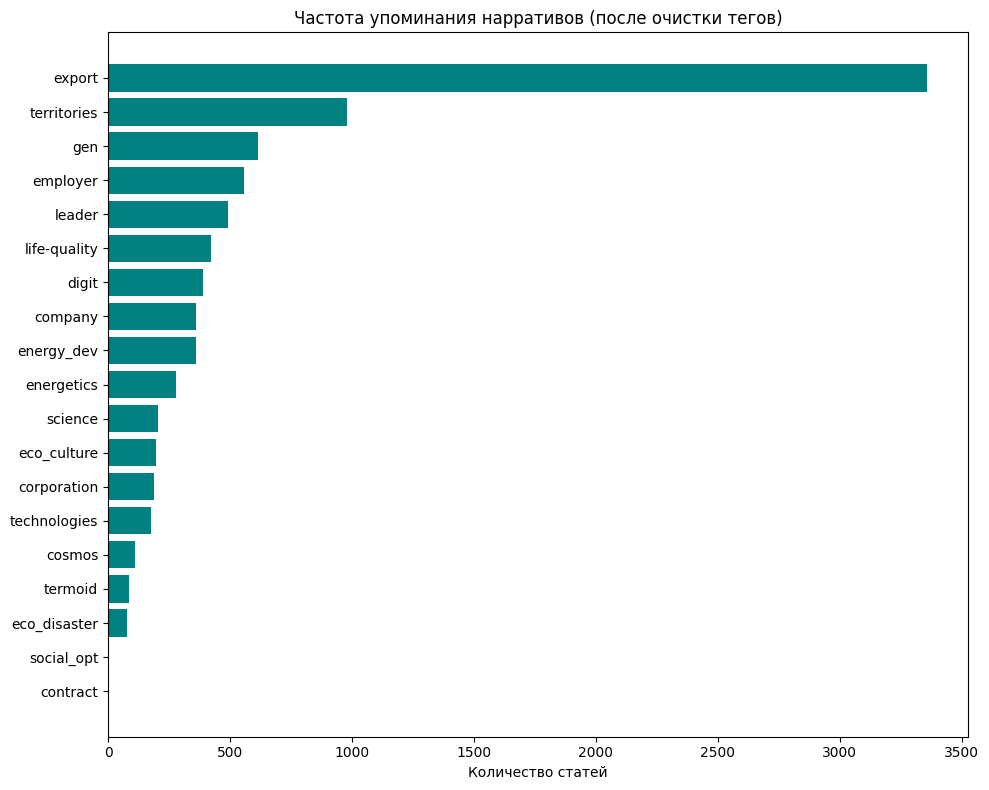

export          = 3357
territories     = 978
gen             = 613
employer        = 559
leader          = 492
life-quality    = 422
digit           = 391
company         = 362
energy_dev      = 362
energetics      = 279
science         = 206
eco_culture     = 196
corporation     = 189
technologies    = 177
cosmos          = 109
termoid         = 86
eco_disaster    = 77
social_opt      = 3
contract        = 0


In [ ]:
# Подготовка данных
working_df = single_df[['narratives_list']].copy()

# Очистка и разделение
working_df['narrative_split'] = working_df['narratives_list'].astype(str).str.split(',')

# Разворачиваем список в отдельные строки
exploded_df = working_df.explode('narrative_split')

# Очитска от наименований компаний 01 - 09 перед нарративом
def clean_label(text):
    if pd.isna(text) or text == 'nan':
        return text
    text = re.sub(r'\(\d+\)', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Применяем очистку
exploded_df['clean_name'] = exploded_df['clean_name'] = exploded_df['narrative_split'].apply(clean_label)

# Считаем упоминания
counts = exploded_df['clean_name'].value_counts()

# Обновленный маппинг
mapping = {
    'компания национального масштаба': 'company',
    'корпорация знаний': 'corporation',
    'экспорт / конвейер': 'export',
    'развитие ядерной энергетики в стране': 'energy_dev',
    'лидер технологического суверенитета страны': 'leader',
    'космос': 'cosmos',
    'термояд': 'termoid',
    'gen 4': 'gen',
    'наука': 'science',
    'контракт с будущими поколениями': 'contract',
    'цифра': 'digit',
    'энергетика': 'energetics',
    'технологии': 'technologies',
    'решения для ликвидации экологического ущерба': 'eco_disaster',
    'экологическая культура и поведение': 'eco_culture',
    'работодатель №1': 'employer',
    'развитие территорий присутствия': 'territories',
    'повышение качества жизни людей': 'life-quality',
    'социальный оптимизм': 'social_opt'
}

# Собираем финальные цифры в переменные
results = {var_name: counts.get(full_name, 0) for full_name, var_name in mapping.items()}

# Визуализация
plt.figure(figsize=(10, 8))
# Сортируем для красоты
sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))

plt.barh(list(sorted_results.keys()), list(sorted_results.values()), color='teal')
plt.title('Частота упоминания нарративов (после очистки тегов)')
plt.xlabel('Количество статей')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Вывод результатов для проверки
for var, val in sorted_results.items():
    print(f"{var: <15} = {val}")


Статистика выше показывает количество нарративов в датасете безотносительно конкретной компании. На основе цифр выше видим, что распределение нарративов неравное и для корректного обучения модели без перекосов на превалирующие классы необходимо будет их уравнять. Social_opt можно выкинуть, так как он встречается очень редко. eco_disaster, cosmos, termoid нужно будет аугментировать - написать промпт и попросить LLM дописать тексты с этим нарративом. Остальные урезать до значения, которым будут располагать все нарративы - 150.

In [ ]:
pattern = r'\(0[0-8]\)\s*социальный оптимизм'

# Инвертируем выборку: оставляем только те строки, где паттерн НЕ найден
single_df = single_df[
    ~single_df['narratives_list'].str.contains(pattern, case=False, na=False, regex=True)
].copy()

# Сбрасываем индексы
single_df = single_df.reset_index(drop=True)

In [ ]:
single_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8855 entries, 0 to 8854
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     8855 non-null   object
 1   narratives_list  8855 non-null   object
dtypes: object(2)
memory usage: 138.5+ KB


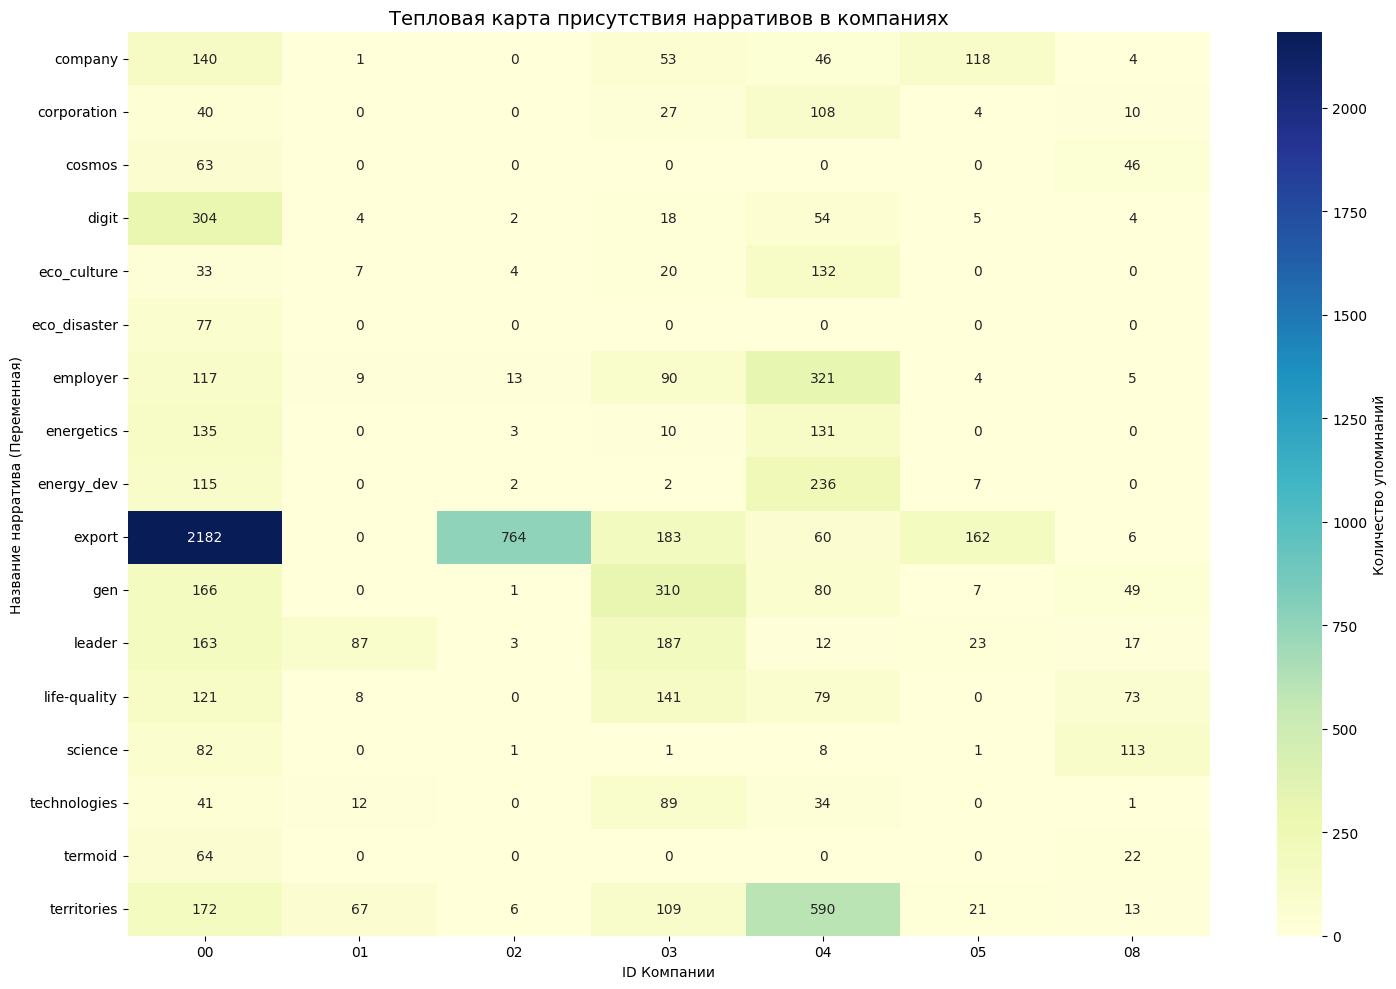

In [ ]:
# 1. Подготовка данных
working_df = single_df[['narratives_list']].copy()
working_df['split'] = working_df['narratives_list'].astype(str).str.split(',')
exploded_df = working_df.explode('split')

# 2. Функция для извлечения компании и текста
def extract_company_and_text(val):
    if pd.isna(val): return None, None

    # Регулярка: поиск цифры в скобках и текста после них
    match = re.search(r'\((\d+)\)\s*(.*)', str(val))
    if match:
        company_id = match.group(1)
        text = re.sub(r'\s+', ' ', match.group(2)).strip().lower()
        return company_id, text
    return None, None

# Применяем извлечение (создаем две новые колонки)
exploded_df[['company_id', 'clean_narrative']] = exploded_df['split'].apply(
    lambda x: pd.Series(extract_company_and_text(x))
)

# Удаляем пустые значения, если они появились при парсинге
exploded_df = exploded_df.dropna(subset=['company_id', 'clean_narrative'])

# Сопоставление с  переменными
mapping = {
    'компания национального масштаба': 'company',
    'корпорация знаний': 'corporation',
    'экспорт / конвейер': 'export',
    'развитие ядерной энергетики в стране': 'energy_dev',
    'лидер технологического суверенитета страны': 'leader',
    'космос': 'cosmos',
    'термояд': 'termoid',
    'gen 4': 'gen',
    'наука': 'science',
    'контракт с будущими поколениями': 'contract',
    'цифра': 'digit',
    'энергетика': 'energetics',
    'технологии': 'technologies',
    'решения для ликвидации экологического ущерба': 'eco_disaster',
    'экологическая культура и поведение': 'eco_culture',
    'работодатель №1': 'employer',
    'развитие территорий присутствия': 'territories',
    'повышение качества жизни людей': 'life-quality'
}

# Заменяем полные названия на короткие переменные для графиков
exploded_df['var_name'] = exploded_df['clean_narrative'].map(mapping)

# Готовим таблицу сопряженности (Cross-tabulation)
ct = pd.crosstab(exploded_df['company_id'], exploded_df['var_name'])
ct_pct = ct.div(ct.sum(1), axis=0)

plt.figure(figsize=(15, 10))
sns.heatmap(ct.T, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Количество упоминаний'})

plt.title('Тепловая карта присутствия нарративов в компаниях', fontsize=14)
plt.xlabel('ID Компании')
plt.ylabel('Название нарратива (Переменная)')
plt.tight_layout()
plt.show()

С помощью тепловой карты можно понять распределение нарартивов по каждой из компаний 00 - 08. При необходимости на ее основе можно сформировать датасет с упором на конретные дочерние компании 01-08 или на компанию интегратор 00. На данном этапе такой задачи не стоит, но проверить было интересно.

In [ ]:
single_df['narratives_list'].unique()

# Формируем датасет

Данный датасет будет основан на single_df, то есть мф сфокусируемся на определении в текста ведущего нарратива.

In [ ]:
import pandas as pd
import re


SAMPLES_PER_NARRATIVE = 150
RANDOM_STATE = 42

no_digits = single_df.copy()


no_digits['narratives_list'] = (
    no_digits['narratives_list']
    .str.lower()
    .str.replace(r'\(\d+\)', '', regex=True)  # удаляем (00), (01), ...
    .str.replace(r'\d+', '', regex=True)      # удаляем оставшиеся цифры
    .str.replace(r'[^\w\s/№]', ' ', regex=True)  # убираем лишние знаки
    .str.replace(r'\s+', ' ', regex=True)     # схлопываем пробелы
    .str.strip()                              # убираем пробелы по краям
)


# Проверка: смотрим, какие нарративы получились
narrative_counts_before = (
    no_digits['narratives_list']
    .value_counts()
    .sort_index()
)

print('Количество объектов по нарративам ДО сэмплирования:')
print(narrative_counts_before)
print('-' * 80)


# если строк меньше 150 - берём все

def safe_sample(group: pd.DataFrame) -> pd.DataFrame:
    """
    group: pandas.DataFrame — все строки одного нарратива

    Возвращает:
    - либо 150 случайных строк
    - либо все строки, если их меньше 150
    """
    if len(group) <= SAMPLES_PER_NARRATIVE:
        return group
    return group.sample(n=SAMPLES_PER_NARRATIVE, random_state=RANDOM_STATE)


# Формируем финальный filtered_df

filtered_df = (
    no_digits
    .groupby('narratives_list', group_keys=False)
    .apply(safe_sample)
    .reset_index(drop=True)
)


# Проверка после сэмплирования

narrative_counts_after = (
    filtered_df['narratives_list']
    .value_counts()
    .sort_index()
)

print('Количество объектов по нарративам ПОСЛЕ сэмплирования:')
print(narrative_counts_after)
print('-' * 80)



Количество объектов по нарративам ДО сэмплирования:
narratives_list
gen                                              613
компания национального масштаба                  362
корпорация знаний                                189
космос                                           109
лидер технологического суверенитета страны       492
наука                                            206
повышение качества жизни людей                   422
работодатель №                                   559
развитие территорий присутствия                  978
развитие ядерной энергетики в стране             362
решения для ликвидации экологического ущерба      77
термояд                                           86
технологии                                       177
цифра                                            391
экологическая культура и поведение               196
экспорт / конвейер                              3357
энергетика                                       279
Name: count, dtype: int64
-----

/tmp/ipython-input-4210478271.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(safe_sample)


In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2372 entries, 0 to 2371
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     2372 non-null   object
 1   narratives_list  2372 non-null   object
dtypes: object(2)
memory usage: 37.2+ KB


In [ ]:
file_name = r'big_classification_filtered.xlsx'
filtered_df.to_excel(file_name, index = False)

In [ ]:
filtered_df = pd.read_excel(r'/content/big_classification_filtered.xlsx')

Посмотрели сколько нарративов после добавления синтетических данных и увидим, что их практически везде 150 или чуть поменьше, но не существенно.

In [ ]:

narrative_counts_after = (
    filtered_df['narratives_list']
    .value_counts()
    .sort_index()
)

print(narrative_counts_after)
print('-' * 80)

Количество объектов по нарративам ПОСЛЕ сэмплирования:
narratives_list
gen                                             150
компания национального масштаба                 150
корпорация знаний                               150
космос                                          149
лидер технологического суверенитета страны      150
наука                                           150
повышение качества жизни людей                  150
работодатель №                                  150
развитие территорий присутствия                 150
развитие ядерной энергетики в стране            150
решения для ликвидации экологического ущерба    128
термояд                                         104
технологии                                      150
цифра                                           150
экологическая культура и поведение              150
экспорт / конвейер                              150
энергетика                                      150
Name: count, dtype: int64
-------------------

In [ ]:
Очищаем новые тексты от лишних сиволов

In [ ]:

filtered_df['article_text'] = filtered_df['article_text'].str.replace(r'http\S+|www\S+', '', regex=True)
filtered_df['article_text'] = filtered_df['article_text'].str.lower()
filtered_df['article_text'] = filtered_df['article_text'].str.replace(r'[^а-яёa-z0-9\s]', ' ', regex=True)
filtered_df['article_text'] = filtered_df['article_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
Убеждаемся, что нет потворяющихся меток из-за возникновения пробелов или других символов

In [ ]:
filtered_df['narratives_list'].unique()

array(['gen', 'компания национального масштаба', 'корпорация знаний',
       'космос', 'лидер технологического суверенитета страны', 'наука',
       'повышение качества жизни людей', 'работодатель №',
       'развитие территорий присутствия',
       'развитие ядерной энергетики в стране',
       'решения для ликвидации экологического ущерба', 'термояд',
       'технологии', 'цифра', 'экологическая культура и поведение',
       'экспорт / конвейер', 'энергетика'], dtype=object)

Трансформируем метки категориальных признаков в числовые

In [ ]:
le = LabelEncoder()
# Обучаем энкодер на всех уникальных нарративах из вашей колонки
le.fit(filtered_df['narratives_list'])

# Создаем новую колонку с кодами
filtered_df['narrative_codes'] = le.transform(filtered_df['narratives_list'])

In [ ]:
# Выпишем код и название метки, чтобы потом удобнее было проверять
for index, label in enumerate(le.classes_):
    print(f"Код {index}: {label}")

Код 0: gen
Код 1: компания национального масштаба
Код 2: корпорация знаний
Код 3: космос
Код 4: лидер технологического суверенитета страны
Код 5: наука
Код 6: повышение качества жизни людей
Код 7: работодатель №
Код 8: развитие территорий присутствия
Код 9: развитие ядерной энергетики в стране
Код 10: решения для ликвидации экологического ущерба
Код 11: термояд
Код 12: технологии
Код 13: цифра
Код 14: экологическая культура и поведение
Код 15: экспорт / конвейер
Код 16: энергетика


In [ ]:
filtered_df = filtered_df.drop('narratives_list', axis = 1)

In [ ]:
filtered_df.head()

,article_text,narrative_codes
0,москва 20 февраля тасс нейросети сегодня отмеч...,0
1,москва 29 сен прайм оборудование ядерного реак...,0
2,москва 19 сен риа новости сотрудники националь...,0
3,в городе сочи прошла всероссийская конференция...,0
4,владивосток 5 сен риа новости росатом предлага...,0


# Обучение логистической регрессии

In [ ]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/classification_model'
if not os.path.exists(path):
    os.makedirs(path)

Mounted at /content/drive


In [ ]:
# Загрузка предварительно обученной модели и токенизатора на текстах из того же инфополя и по той же тематике, что и нарративные
model_path = '/content/drive/MyDrive/model/checkpoint_epoch_1.pt'
save_path = '/content/drive/MyDrive/model/'
model = AutoModel.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=Fals

Используемое устройство: cuda
Извлекаем эмбеддинги из BERT...
Обучаем логистическую регрессию...


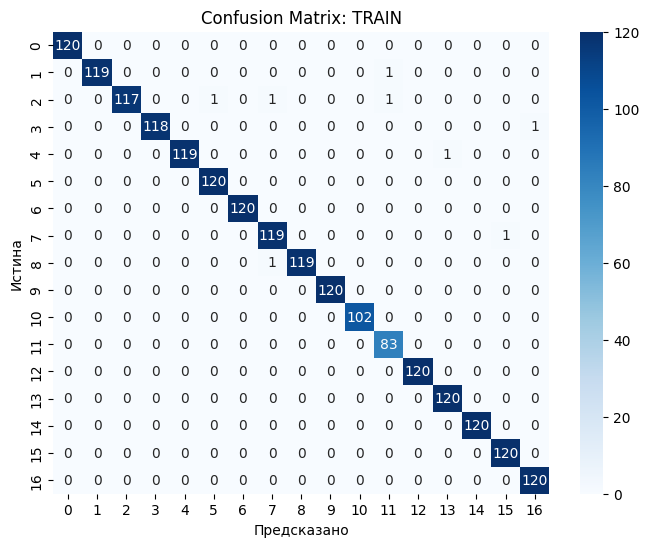

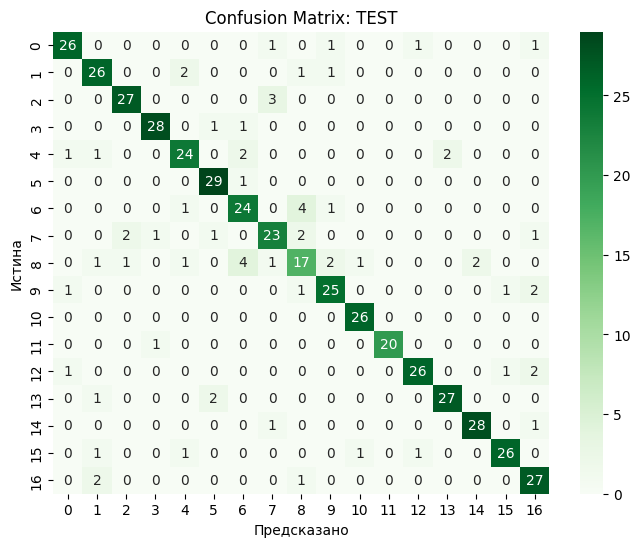

Обучение завершено. Метрики на тесте:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        30
           1       0.81      0.87      0.84        30
           2       0.90      0.90      0.90        30
           3       0.93      0.93      0.93        30
           4       0.83      0.80      0.81        30
           5       0.88      0.97      0.92        30
           6       0.75      0.80      0.77        30
           7       0.79      0.77      0.78        30
           8       0.65      0.57      0.61        30
           9       0.83      0.83      0.83        30
          10       0.93      1.00      0.96        26
          11       1.00      0.95      0.98        21
          12       0.93      0.87      0.90        30
          13       0.93      0.90      0.92        30
          14       0.93      0.93      0.93        30
          15       0.93      0.87      0.90        30
          16       0.79      0.90      0.84

In [ ]:

path = '/content/drive/My Drive/classification_model'
if not os.path.exists(path):
    os.makedirs(path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


model.to(device)

# Функция получения эмбеддингов
def get_embeddings(str_list, model, tokenizer, device, batch_size=16):
    model.eval()
    all_embeddings = []

    for i in range(0, len(str_list), batch_size):
        batch_texts = str_list[i:i + batch_size]
        encoded_dict = tokenizer.batch_encode_plus(
            batch_texts,
            add_special_tokens=True,
            truncation=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings.cpu().numpy())

    return np.vstack(all_embeddings)

# Извлекаем эмбеддинги один раз для всего датасета
print("Извлекаем эмбеддинги из BERT...")
all_texts = filtered_df['article_text'].astype(str).tolist()
X_embeddings = get_embeddings(all_texts, model, tokenizer, device)
y = filtered_df['narrative_codes'].values

# разделяем на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Инициализация и обучение модели
clf = LogisticRegression(
    C=0.5,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

print("Обучаем логистическую регрессию...")
clf.fit(X_train, y_train)

# Оценка качества
def evaluate_model(model, X, y_true, set_name):
    y_pred = model.predict(X)
    metrics = {
        'dataset': set_name,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted'),
        'recall': recall_score(y_true, y_pred, average='weighted'),
        'f1': f1_score(y_true, y_pred, average='weighted')
    }

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues' if set_name == 'train' else 'Greens')
    plt.title(f'Confusion Matrix: {set_name.upper()}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истина')
    plt.savefig(os.path.join(path, f'cm_{set_name}.png'))
    plt.show()
    return metrics, y_pred

train_metrics, _ = evaluate_model(clf, X_train, y_train, 'train')
test_metrics, y_test_pred = evaluate_model(clf, X_test, y_test, 'test')

# Сохранение результатов
df_res = pd.DataFrame([train_metrics, test_metrics])
df_res.to_csv(os.path.join(path, 'all_metrics.csv'), index=False)
joblib.dump(clf, os.path.join(path, 'logreg_model.pkl'))

print(f"Обучение завершено. Метрики на тесте:\n{classification_report(y_test, y_test_pred)}")

В данном случае, я бы огриентировалась на полноту класса и f1 метрику. У классов 6,7,8 - повышение качечества жизни, работодатель, развитие территорий эти показатели ниже всех остальных.  

# Тестируем на реальных текстах

Помимо метрик, считаю очень важным протестировать модель на реальных данных, чтобы понять, насколько метрические резальтаты сооветствуют действительности и удовлетворят потребность заказчика.

In [ ]:

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка модели и токенизатора
model_path = '/content/drive/MyDrive/model/checkpoint_epoch_1.pt'
save_path = '/content/drive/MyDrive/model/'
model = AutoModel.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
df = pd.read_excel(r'/content/Проверка.xlsx')

In [ ]:
# Извлекаем тексты из DataFrame
str_list_container = df.iloc[:]['adjusted_text'].astype(str).tolist()  # Замените 'text' на имя вашего столбца

# Проверяем количество извлеченных текстов
print(f"Количество текстов: {len(str_list_container)}")
print("Пример первого текста:", str_list_container[0][:100] + "...")

Количество текстов: 12
Пример первого текста: Посол России в Индонезии Сергей Толченов заявил, что Москва готова поделиться с республикой решениям...


In [ ]:
# Функция для получения эмбеддингов
def get_embeddings(str_list_container ):
    input_ids = []
    attention_masks = []


    for text in str_list_container:
        encoded_dict = tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0).to(device)
    attention_masks = torch.cat(attention_masks, dim=0).to(device)

    with torch.no_grad():
        # Получаем выходные эмбеддинги из модели
        outputs = model(input_ids=input_ids, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state.mean(dim=1)  # Используем средний пуллинг
        return embeddings.cpu().numpy()

# Получаем эмбеддинги для текстов
embeddings = get_embeddings(str_list_container )

In [ ]:
path_to_model = '/content/drive/My Drive/classification_model/logreg_model.pkl'
loaded_model = joblib.load(path_to_model)

In [ ]:
# Структура данных: Словарь (dict) в Python
# Ключ (int): код класса, Значение (str): название класса
mapping = {
    0: "gen",
    1: "компания национального масштаба",
    2: "корпорация знаний",
    3: "космос",
    4: "лидер технологического суверенитета страны",
    5: "наука",
    6: "повышение качества жизни людей",
    7: "работодатель №",
    8: "развитие территорий присутствия",
    9: "развитие ядерной энергетики в стране",
    10: "решения для ликвидации экологического ущерба",
    11: "термояд",
    12: "технологии",
    13: "цифра",
    14: "экологическая культура и поведение",
    15: "экспорт / конвейер",
    16: "энергетика"
}

# Получаем численные предсказания
numeric_predictions = loaded_model.predict(embeddings)

# Трансформируем цифры в слова без использования LabelEncoder
df['Narratives_Predicted'] = pd.Series(numeric_predictions).map(mapping).values

# Вероятности
probs = loaded_model.predict_proba(embeddings)
df['Probabilities'] = probs.max(axis=1)


print(df[['Narratives_Predicted', 'Probabilities']].head())

              Narratives_Predicted  Probabilities
0               экспорт / конвейер       0.992414
1               экспорт / конвейер       0.976860
2               экспорт / конвейер       0.891996
3                              gen       0.977013
4  развитие территорий присутствия       0.715487


In [ ]:
df.head(15)

,adjusted_text,True Narratives,Predicted Narratives,Narratives_Predicted,Probabilities
0,Посол России в Индонезии Сергей Толченов заяви...,Экспорт,NaN,экспорт / конвейер,0.992414
1,"ТАШКЕНТ, 30 янв - РИА Новости. Строительство а...",Энергетика,NaN,экспорт / конвейер,0.976860
2,Около строящейся в Узбекистане атомной электро...,Цифра,NaN,экспорт / конвейер,0.891996
3,"ТОМСК, 30 декабря. /ТАСС/. Госкорпорация ""Роса...",gen 4,NaN,gen,0.977013
4,Год 80-летия атомной промышленности России Кол...,Работодатель,NaN,развитие территорий присутствия,0.715487
5,Космические корабли учатся возвращаться на Зем...,космос (длинный текст),NaN,космос,0.999815
6,На III международном форуме AMTEXPO 2026 Кирил...,лидерт тех суверенитета,NaN,лидер технологического суверенитета страны,0.425353
7,Россия подарила миру направление исследований ...,термояд,NaN,термояд,0.654245
8,Спорт и здоровый образ жизни способствуют сохр...,Развитие тер присутствия,NaN,развитие территорий присутствия,0.551045
9,Проект по сооружению КолАЭС-2 усилит энергетич...,Развитие ядерной энерегтики,NaN,развитие ядерной энергетики в стране,0.825002


В целом, большая часть разметки человека (True Narratives) и модель (Narratives predicted) совпадает. Далее хочется попробовать покрыть те случаи, когда нарративов может быть несколько, сооветственно нужно использовать MultiOutputClassifier

# Подход с MultiOutputClassifier

Берем датасет с синтетическими данными и ровным количеством статей по классам (single_df) и датасет с несколькими метками нарративов на один текст (duo_df), формируем единый датафрейм. Это необходимо, чтобы модель училась в том числе на тех случаях, где нарратривы пересекаются в рамках одного текста. Поскольку кол-во статей примерно одинаковое, то склеиваем как есть.

In [ ]:
filtered_df = pd.read_excel(r'/content/big_classification_filtered.xlsx')
duo_df_clean = pd.read_excel(r'/content/duo_df_clean.xlsx')

In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     2481 non-null   object
 1   narratives_list  2481 non-null   object
dtypes: object(2)
memory usage: 38.9+ KB


In [ ]:
duo_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2525 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     2525 non-null   object
 1   narratives_list  2525 non-null   object
dtypes: object(2)
memory usage: 39.6+ KB


In [ ]:
mixed_df = pd.concat([filtered_df, duo_df_clean])

In [ ]:
mixed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5006 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     5006 non-null   object
 1   narratives_list  5006 non-null   object
dtypes: object(2)
memory usage: 117.3+ KB


Чистим колонку с текстом от лишней пунктуации, пробелов и ссылок, а колонку с нарративами - от цифр

In [ ]:

mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'http\S+|www\S+', '', regex=True)
mixed_df['article_text'] = mixed_df['article_text'].str.lower()
mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'[^а-яёa-z0-9\s]', ' ', regex=True)
mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
mixed_df['narratives_list'] = (
    mixed_df['narratives_list']
    .str.lower()  # pandas.Series.str → приводит к нижнему регистру
    .str.replace(r'\(\d+\)', '', regex=True)  # удаляет (00), (01), ...
    .str.replace(r'\s+', ' ', regex=True)     # схлопываем пробелы
    .str.strip()                              # убираем пробелы по краям
)

In [ ]:
mixed_df['narratives_list'].unique()

array(['gen', 'компания национального масштаба', 'корпорация знаний',
       'космос', 'лидер технологического суверенитета страны', 'наука',
       'повышение качества жизни людей', 'работодатель №',
       'развитие территорий присутствия',
       'развитие ядерной энергетики в стране',
       'решения для ликвидации экологического ущерба', 'термояд',
       'технологии', 'цифра', 'экологическая культура и поведение',
       'экспорт / конвейер', 'энергетика',
       'компания национального масштаба, gen 4, лидер технологического суверенитета страны, gen 4, развитие ядерной энергетики в стране, компания национального масштаба, космос, наука, повышение качества жизни людей',
       'компания национального масштаба, работодатель №1, энергетика',
       'gen 4, компания национального масштаба',
       'лидер технологического суверенитета страны, повышение качества жизни людей',
       'gen 4, наука',
       'контракт с будущими поколениями, работодатель №1, развитие ядерной энергетики в

In [ ]:
file_name = r'mixed_df.xlsx'
mixed_df.to_excel(file_name, index = False)

In [ ]:
mixed_df['narratives_list'] = mixed_df['narratives_list'].str.split(',')

In [ ]:
mixed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5006 entries, 0 to 2524
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     5006 non-null   object
 1   narratives_list  5006 non-null   object
dtypes: object(2)
memory usage: 117.3+ KB


In [ ]:
# Раскрываем списки в отдельные строки
exploded_narratives = mixed_df.copy()
exploded_narratives = exploded_narratives['narratives_list'].explode()

# Теперь мы можем посмотреть уникальные значения и их количество
print(exploded_narratives.value_counts())

narratives_list
компания национального масштаба                  690
gen 4                                            568
 экспорт / конвейер                              560
 наука                                           515
 энергетика                                      482
лидер технологического суверенитета страны       466
наука                                            374
экспорт / конвейер                               363
 gen 4                                           326
 развитие ядерной энергетики в стране            281
 повышение качества жизни людей                  273
 лидер технологического суверенитета страны      259
повышение качества жизни людей                   257
развитие ядерной энергетики в стране             243
корпорация знаний                                235
развитие территорий присутствия                  209
технологии                                       200
цифра                                            189
экологическая культура и повед

In [ ]:
def clean_narratives_final(tags_list):
    if not isinstance(tags_list, list):
        return []

    cleaned = set()

    for item in tags_list:
        # 1. Применяем .strip() из стандартной библиотеки Python для удаления пробелов
        name = item.strip()

        # 2. Маппинг (склейка) похожих нарративов
        if name in ["gen", "gen 4"]:
            name = "gen 4"
        elif name in ["работодатель №", "работодатель №1"]:
            name = "работодатель №1"

        # 3. Фильтрация: убираем "социальный оптимизм" и пустые строки
        if name and name != "социальный оптимизм":
            cleaned.add(name)

    return list(cleaned)

# Применяем к колонке нашего DataFrame
mixed_df['narratives_list'] = mixed_df['narratives_list'].apply(clean_narratives_final)

# Финальная проверка распределения
print(mixed_df['narratives_list'].explode().value_counts())

narratives_list
экспорт / конвейер                              833
gen 4                                           825
наука                                           818
компания национального масштаба                 755
лидер технологического суверенитета страны      674
энергетика                                      576
повышение качества жизни людей                  512
развитие ядерной энергетики в стране            503
работодатель №1                                 415
корпорация знаний                               408
развитие территорий присутствия                 379
цифра                                           342
космос                                          270
технологии                                      261
термояд                                         235
экологическая культура и поведение              205
решения для ликвидации экологического ущерба    140
контракт с будущими поколениями                  25
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Обучаемся и трансформируем данные
y = mlb.fit_transform(mixed_df['narratives_list'])

# Теперь y — это матрица из 0 и 1, которую поймет MultiOutputClassifier
print(f"Формат матрицы y: {y.shape}") # количество_текстов, количество_уникальных_нарративов)
print(f"Список классов: {mlb.classes_}")

Формат матрицы y: (5006, 18)
Список классов: ['gen 4' 'компания национального масштаба'
 'контракт с будущими поколениями' 'корпорация знаний' 'космос'
 'лидер технологического суверенитета страны' 'наука'
 'повышение качества жизни людей' 'работодатель №1'
 'развитие территорий присутствия' 'развитие ядерной энергетики в стране'
 'решения для ликвидации экологического ущерба' 'термояд' 'технологии'
 'цифра' 'экологическая культура и поведение' 'экспорт / конвейер'
 'энергетика']


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка модели и токенизатора
model_path = '/content/drive/MyDrive/model/checkpoint_epoch_1.pt'
save_path = '/content/drive/MyDrive/model/'
model = AutoModel.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Loading weights:   0%|          | 0/199 [00:02<?, ?it/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Извлекаем тексты из DataFrame
str_list_container = mixed_df.iloc[:]['article_text'].astype(str).tolist()  # Замените 'text' на имя вашего столбца

# Проверяем количество извлеченных текстов
print(f"Количество текстов: {len(str_list_container)}")
print("Пример первого текста:", str_list_container[0][:100] + "...")

Количество текстов: 5006
Пример первого текста: москва 20 февраля тасс нейросети сегодня отмечают лидирующую роль россии в области применения лазерн...


In [ ]:

path = '/content/drive/My Drive/classification_model'
if not os.path.exists(path):
    os.makedirs(path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


model.to(device)



def get_embeddings(str_list, batch_size=16):
    model.eval()
    all_embeddings = []


    for i in range(0, len(str_list), batch_size):
        batch_texts = str_list[i:i + batch_size]

        # Токенизируем только текущий батч
        encoded_dict = tokenizer(
            batch_texts,
            add_special_tokens=True,
            truncation=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Переносим на GPU
        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            # Извлекаем эмбеддинги
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings.cpu().numpy())

        # Освобождаем память GPU от тензоров текущего батча
        del input_ids, attention_masks, outputs
        torch.cuda.empty_cache()

    return np.vstack(all_embeddings)


X_embeddings = get_embeddings(str_list_container)

# Подготовка данных для обучения
print("Трансформация меток в бинарную матрицу...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(mixed_df['narratives_list'])


# Сплит данных
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings,
    y,
    test_size=0.2,
    random_state=42
)

# Обучение MultiOutput модели
base_lr = LogisticRegression(
    C=0.5,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Оборачиваем в MultiOutputClassifier для независимого обучения по каждой метке
clf = MultiOutputClassifier(base_lr, n_jobs=-1)

print("Запуск обучения модели...")
clf.fit(X_train, y_train)

# --- 5. Оценка и интерпретация ---
def evaluate_multilabel(model, X, y_true, mlb, set_name):
    y_pred = model.predict(X)

    print(f"\n--- Отчет для {set_name.upper()} ---")
    print(classification_report(y_true, y_pred, target_names=mlb.classes_))

    metrics = {
        'accuracy_subset': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_samples': f1_score(y_true, y_pred, average='samples')
    }
    return metrics

train_metrics = evaluate_multilabel(clf, X_train, y_train, mlb, 'train')
test_metrics = evaluate_multilabel(clf, X_test, y_test, mlb, 'test')

# Сохранение артефактов
joblib.dump(clf, os.path.join(path, 'multioutput_logreg.pkl'))
joblib.dump(mlb, os.path.join(path, 'mlb_transformer.pkl'))

# Сохраняем метрики
pd.DataFrame([train_metrics, test_metrics], index=['train', 'test']).to_csv(os.path.join(path, 'metrics.csv'))

print(f"\nГотово! Модель и трансформер меток сохранены в {path}")


sample_pred = clf.predict(X_test[:18])
decoded_labels = mlb.inverse_transform(sample_pred)
print(f"Пример предсказания для первого текста: {decoded_labels[0]}")

Используемое устройство: cuda
Трансформация меток в бинарную матрицу...
Запуск обучения модели...

--- Отчет для TRAIN ---
                                              precision    recall  f1-score   support

                                       gen 4       0.97      0.94      0.95       658
             компания национального масштаба       0.92      0.81      0.86       594
             контракт с будущими поколениями       1.00      0.94      0.97        18
                           корпорация знаний       0.94      0.83      0.88       334
                                      космос       0.99      0.95      0.97       215
  лидер технологического суверенитета страны       0.92      0.82      0.87       532
                                       наука       0.93      0.90      0.92       659
              повышение качества жизни людей       0.97      0.94      0.95       428
                             работодатель №1       0.92      0.81      0.86       322
             раз

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Тестируем MultiOutputClassifier на текстах

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/MyDrive/model/checkpoint_epoch_1.pt'
save_path = '/content/drive/MyDrive/model/'
model = AutoModel.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import joblib

# --- 1. Настройки и загрузка ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_artifacts = '/content/drive/My Drive/classification_model'

# Загружаем наши "артефакты"
loaded_model = joblib.load(os.path.join(path_to_artifacts, 'multioutput_logreg.pkl'))
mlb = joblib.load(os.path.join(path_to_artifacts, 'mlb_transformer.pkl'))

# Загружаем данные для проверки
df = pd.read_excel(r'/content/Проверка_расширенная.xlsx')
str_list_container = df['adjusted_text'].astype(str).tolist()


def get_embeddings_safe(str_list, batch_size=16):
    model.eval()
    all_embeddings = []
    for i in range(0, len(str_list), batch_size):
        batch_texts = str_list[i:i + batch_size]
        encoded_dict = tokenizer(batch_texts, truncation=True, max_length=512,
                                 padding='max_length', return_tensors='pt')

        ids = encoded_dict['input_ids'].to(device)
        mask = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=ids, attention_mask=mask)
            # Mean Pooling (среднее по скрытым состояниям)
            emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(emb)

        del ids, mask, outputs
        torch.cuda.empty_cache()
    return np.vstack(all_embeddings)

print("Извлекаем эмбеддинги...")
embeddings = get_embeddings_safe(str_list_container)



# Получаем бинарную матрицу (0 и 1)
binary_predictions = loaded_model.predict(embeddings)

# Трансформируем 0 и 1 в названия нарративов

df['Narratives_Predicted'] = mlb.inverse_transform(binary_predictions)

# Шаг 3: Расчет вероятностей
probs_all_classes = loaded_model.predict_proba(embeddings)

# Извлекаем вероятность "единицы" для каждого класса и берем максимальную для строки
probs_matrix = np.array([p[:, 1] for p in probs_all_classes]).T
df['Max_Probability'] = probs_matrix.max(axis=1)

# Вывод результата
print("-" * 30)
print(df[['adjusted_text', 'Narratives_Predicted', 'Max_Probability']].head())



Извлекаем эмбеддинги...
------------------------------
                                       adjusted_text  \
0  Одна из приоритетных задач атомной отрасли - р...   
1  В зеленогорский городской Дворец культуры (ЗГК...   
2  Основное внимание на встрече было уделено реал...   
3  Росатом комплексно подходит к развитию электро...   
4  Экскурсии и технические туры на объекты атомно...   

                                Narratives_Predicted  Max_Probability  
0                                                 ()         0.458036  
1  (развитие территорий присутствия, развитие яде...         0.899027  
2                 (развитие территорий присутствия,)         0.999915  
3  (лидер технологического суверенитета страны, п...         0.949272  
4   (экологическая культура и поведение, энергетика)         0.791153  


In [ ]:
df.head(15)

,adjusted_text,True Narratives,Predicted Narratives,Narratives_Predicted,Max_Probability
0,Посол России в Индонезии Сергей Толченов заяви...,Экспорт,NaN,"(экспорт / конвейер,)",0.999927
1,"ТАШКЕНТ, 30 янв - РИА Новости. Строительство а...",Энергетика,NaN,"(экспорт / конвейер,)",0.956815
2,Около строящейся в Узбекистане атомной электро...,Цифра,NaN,(),0.294337
3,"ТОМСК, 30 декабря. /ТАСС/. Госкорпорация ""Роса...",gen 4,NaN,"(gen 4,)",0.998273
4,Год 80-летия атомной промышленности России Кол...,Работодатель,NaN,"(развитие территорий присутствия,)",0.993129
5,Космические корабли учатся возвращаться на Зем...,космос (длинный текст),NaN,"(космос,)",0.999991
6,На III международном форуме AMTEXPO 2026 Кирил...,лидерт тех суверенитета,NaN,"(компания национального масштаба, лидер технол...",0.893400
7,Россия подарила миру направление исследований ...,термояд,NaN,"(термояд,)",0.951766
8,Спорт и здоровый образ жизни способствуют сохр...,Развитие тер присутствия,NaN,"(развитие территорий присутствия,)",0.998025
9,Проект по сооружению КолАЭС-2 усилит энергетич...,Развитие ядерной энерегтики,NaN,"(gen 4, развитие территорий присутствия, разви...",0.986941


In [ ]:
df.to_excel('/content/Результаты_расширенной_Проверки.xlsx', index=False)

# MultiOutput с более прицеленным датасетом

В качестве эксперимента изменим соотношение данных с 1 нарративом и с несколькими. Возьмем 15% текстов с двумя и более нарративами и оставим бОльшую часть датасета с 1 нарративом.

In [ ]:
filtered_df = pd.read_excel(r'/content/big_classification_filtered.xlsx')
duo_df_clean = pd.read_excel(r'/content/duo_df_clean.xlsx')

In [ ]:
short_duo = duo_df_clean.loc[:500]

In [ ]:
short_duo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     501 non-null    object
 1   narratives_list  501 non-null    object
dtypes: object(2)
memory usage: 8.0+ KB


In [ ]:
mixed_df = pd.concat([filtered_df,short_duo])

In [ ]:
mixed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2982 entries, 0 to 500
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   article_text     2982 non-null   object
 1   narratives_list  2982 non-null   object
dtypes: object(2)
memory usage: 69.9+ KB


In [ ]:

mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'http\S+|www\S+', '', regex=True)
mixed_df['article_text'] = mixed_df['article_text'].str.lower()
mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'[^а-яёa-z0-9\s]', ' ', regex=True)
mixed_df['article_text'] = mixed_df['article_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

In [ ]:
mixed_df['narratives_list'] = (
    mixed_df['narratives_list']
    .str.lower()  # pandas.Series.str → приводит к нижнему регистру
    .str.replace(r'\(\d+\)', '', regex=True)  # удаляет (00), (01), ...
    .str.replace(r'\s+', ' ', regex=True)     # схлопываем пробелы
    .str.strip()                              # убираем пробелы по краям
)

In [ ]:
mixed_df['narratives_list'] = mixed_df['narratives_list'].str.split(',')

In [ ]:
def clean_narratives_final(tags_list):
    # Защита от пустых значений (тип None в Python)
    if not isinstance(tags_list, list):
        return []

    cleaned = set() # Используем set (множество), чтобы дубликаты удалялись автоматически

    for item in tags_list:
        # 1. Применяем .strip() из стандартной библиотеки Python для удаления пробелов
        name = item.strip()

        # 2. Маппинг (склейка) похожих нарративов
        if name in ["gen", "gen 4"]:
            name = "gen 4"
        elif name in ["работодатель №", "работодатель №1"]:
            name = "работодатель №1"

        # 3. Фильтрация: убираем "социальный оптимизм" и пустые строки
        if name and name != "социальный оптимизм":
            cleaned.add(name)

    return list(cleaned)

# Применяем к колонке нашего DataFrame
mixed_df['narratives_list'] = mixed_df['narratives_list'].apply(clean_narratives_final)

# Финальная проверка распределения
print(mixed_df['narratives_list'].explode().value_counts())

narratives_list
gen 4                                           354
лидер технологического суверенитета страны      328
наука                                           319
повышение качества жизни людей                  292
компания национального масштаба                 290
экспорт / конвейер                              289
развитие ядерной энергетики в стране            237
энергетика                                      223
космос                                          220
цифра                                           190
развитие территорий присутствия                 180
технологии                                      178
работодатель №1                                 175
корпорация знаний                               154
экологическая культура и поведение              152
термояд                                         142
решения для ликвидации экологического ущерба    128
контракт с будущими поколениями                  13
Name: count, dtype: int64


In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()

# Обучаемся и трансформируем данные
y = mlb.fit_transform(mixed_df['narratives_list'])

# Теперь y — это матрица из 0 и 1, которую "поймет" MultiOutputClassifier
print(f"Формат матрицы y: {y.shape}") # Покажет (количество_текстов, количество_уникальных_нарративов)
print(f"Список классов: {mlb.classes_}")

Формат матрицы y: (2982, 18)
Список классов: ['gen 4' 'компания национального масштаба'
 'контракт с будущими поколениями' 'корпорация знаний' 'космос'
 'лидер технологического суверенитета страны' 'наука'
 'повышение качества жизни людей' 'работодатель №1'
 'развитие территорий присутствия' 'развитие ядерной энергетики в стране'
 'решения для ликвидации экологического ущерба' 'термояд' 'технологии'
 'цифра' 'экологическая культура и поведение' 'экспорт / конвейер'
 'энергетика']


In [ ]:
# 1. Подключаем твой Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загрузка модели и токенизато
model_path = '/content/drive/MyDrive/model/checkpoint_epoch_1.pt'
save_path = '/content/drive/MyDrive/model/'
model = AutoModel.from_pretrained(save_path)
tokenizer = AutoTokenizer.from_pretrained(save_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Извлекаем тексты из DataFrame
str_list_container = mixed_df.iloc[:]['article_text'].astype(str).tolist()  # Замените 'text' на имя вашего столбца

# Проверяем количество извлеченных текстов
print(f"Количество текстов: {len(str_list_container)}")
print("Пример первого текста:", str_list_container[0][:100] + "...")

Количество текстов: 2982
Пример первого текста: москва 20 февраля тасс нейросети сегодня отмечают лидирующую роль россии в области применения лазерн...


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, f1_score, classification_report


path = '/content/drive/My Drive/classification_model'
if not os.path.exists(path):
    os.makedirs(path)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")


model.to(device)



def get_embeddings(str_list, batch_size=16):
    model.eval()
    all_embeddings = []

    # Обработка текстов батчами
    for i in range(0, len(str_list), batch_size):
        batch_texts = str_list[i:i + batch_size]

        # Токенизируем только текущий батч
        encoded_dict = tokenizer(
            batch_texts,
            add_special_tokens=True,
            truncation=True,
            max_length=512,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Переносим на GPU
        input_ids = encoded_dict['input_ids'].to(device)
        attention_masks = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_masks)
            # Извлекаем эмбеддинги (Mean Pooling)
            embeddings = outputs.last_hidden_state.mean(dim=1)
            all_embeddings.append(embeddings.cpu().numpy())


        del input_ids, attention_masks, outputs
        torch.cuda.empty_cache()

    return np.vstack(all_embeddings)


X_embeddings = get_embeddings(str_list_container)

# --- 3. Подготовка данных для обучения ---
print("Трансформация меток в бинарную матрицу...")
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(mixed_df['narratives_list'])


# Сплит данных
X_train, X_test, y_train, y_test = train_test_split(
    X_embeddings,
    y,
    test_size=0.2,
    random_state=42
)

# Обучение MultiOutput модели

base_lr = LogisticRegression(
    C=0.5,
    solver='lbfgs',
    max_iter=1000,
    random_state=42
)

# Оборачиваем в MultiOutputClassifier для независимого обучения по каждой метке
clf = MultiOutputClassifier(base_lr, n_jobs=-1)

print("Запуск обучения модели...")
clf.fit(X_train, y_train)

# Оценка и интерпретация
def evaluate_multilabel(model, X, y_true, mlb, set_name):
    y_pred = model.predict(X)

    print(f"\n--- Отчет для {set_name.upper()} ---")

    print(classification_report(y_true, y_pred, target_names=mlb.classes_))

    metrics = {
        'accuracy_subset': accuracy_score(y_true, y_pred),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'f1_samples': f1_score(y_true, y_pred, average='samples')
    }
    return metrics

train_metrics = evaluate_multilabel(clf, X_train, y_train, mlb, 'train')
test_metrics = evaluate_multilabel(clf, X_test, y_test, mlb, 'test')

# Сохранение артефакто
joblib.dump(clf, os.path.join(path, 'multioutput_logreg_2.pkl'))
joblib.dump(mlb, os.path.join(path, 'mlb_transformer_2.pkl'))

# Сохраняем метрики
pd.DataFrame([train_metrics, test_metrics], index=['train', 'test']).to_csv(os.path.join(path, 'metrics.csv'))

print(f"\nГотово! Модель и трансформер меток сохранены в {path}")

# Пример того, как достать названия нарративов для предсказаний
sample_pred = clf.predict(X_test[:18])
decoded_labels = mlb.inverse_transform(sample_pred)
print(f"Пример предсказания для первого текста: {decoded_labels[0]}")

Используемое устройство: cuda
Трансформация меток в бинарную матрицу...
Запуск обучения модели...

--- Отчет для TRAIN ---
                                              precision    recall  f1-score   support

                                       gen 4       0.98      0.94      0.96       277
             компания национального масштаба       0.99      0.91      0.94       223
             контракт с будущими поколениями       1.00      0.91      0.95        11
                           корпорация знаний       0.99      0.87      0.93       121
                                      космос       0.99      0.98      0.99       174
  лидер технологического суверенитета страны       0.97      0.92      0.95       268
                                       наука       0.97      0.94      0.96       253
              повышение качества жизни людей       0.99      0.93      0.96       240
                             работодатель №1       0.95      0.88      0.92       143
             раз

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Готово! Модель и трансформер меток сохранены в /content/drive/My Drive/classification_model
Пример предсказания для первого текста: ('решения для ликвидации экологического ущерба',)


# Тестируем на расширенном

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import joblib


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
path_to_artifacts = '/content/drive/My Drive/classification_model'


loaded_model = joblib.load(os.path.join(path_to_artifacts, 'multioutput_logreg.pkl'))
mlb = joblib.load(os.path.join(path_to_artifacts, 'mlb_transformer.pkl'))


df = pd.read_excel(r'/content/Проверка_расширенная.xlsx')
str_list_container = df['adjusted_text'].astype(str).tolist()


def get_embeddings_safe(str_list, batch_size=16):
    model.eval()
    all_embeddings = []
    for i in range(0, len(str_list), batch_size):
        batch_texts = str_list[i:i + batch_size]
        encoded_dict = tokenizer(batch_texts, truncation=True, max_length=512,
                                 padding='max_length', return_tensors='pt')

        ids = encoded_dict['input_ids'].to(device)
        mask = encoded_dict['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=ids, attention_mask=mask)
            # Mean Pooling (среднее по скрытым состояниям)
            emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
            all_embeddings.append(emb)

        del ids, mask, outputs
        torch.cuda.empty_cache()
    return np.vstack(all_embeddings)

print("Извлекаем эмбеддинги...")
embeddings = get_embeddings_safe(str_list_container)



#Получаем бинарную матрицу (0 и 1)
binary_predictions = loaded_model.predict(embeddings)

# Трансформируем 0 и 1 в названия нарративов
df['Narratives_Predicted'] = mlb.inverse_transform(binary_predictions)

# Расчет вероятностей (для MultiOutput это сложнее)
probs_all_classes = loaded_model.predict_proba(embeddings)

# Извлекаем вероятность "единицы" для каждого класса и берем максимальную для строки
probs_matrix = np.array([p[:, 1] for p in probs_all_classes]).T
df['Max_Probability'] = probs_matrix.max(axis=1)

# Вывод результата
print("-" * 30)
print(df[['adjusted_text', 'Narratives_Predicted', 'Max_Probability']].head())


Извлекаем эмбеддинги...
------------------------------
                                       adjusted_text  \
0  Одна из приоритетных задач атомной отрасли - р...   
1  В зеленогорский городской Дворец культуры (ЗГК...   
2  Основное внимание на встрече было уделено реал...   
3  Росатом комплексно подходит к развитию электро...   
4  Экскурсии и технические туры на объекты атомно...   

                                Narratives_Predicted  Max_Probability  
0                                                 ()         0.458036  
1  (развитие территорий присутствия, развитие яде...         0.899027  
2                 (развитие территорий присутствия,)         0.999915  
3  (лидер технологического суверенитета страны, п...         0.949272  
4   (экологическая культура и поведение, энергетика)         0.791153  


In [ ]:
df.to_excel('/content/Результаты_расширенной_Проверки_2.xlsx', index=False)

Результаты не поменялись. Вне зависимости от наполнения датасета - качественно результаты одинаковые.